## IMPORT STATEMENTS

In [516]:
import pandas as pd
import numpy as np
import nltk
import re 
import os
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import LancasterStemmer
from collections import defaultdict
import pickle
# import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
import tensorflow_hub as hub
import numpy as np
from scipy.spatial.distance import cosine
from itertools import chain
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## STOP WORDS INITIALIZATION

In [517]:
stop_words = set()
languages = ['english','hindi']
for lang in languages:
    with open(lang+".txt",'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.rstrip()
            stop_words.add(line)

print(stop_words)

{'become', 'four', 'hers', 'abroad', 'वे', 'act', 'haven', 'somehow', 'way', 'apparently', 'pm', 'nos', 'doing', 'readily', 'kz', 'ao', 'approximately', 'ml', 'पे', 'into', 'tn', 'eg', "we'll", 'faces', 'opening', 'thatve', 'thered', 'hardly', 'इन्हें', 'backward', 'front', 'members', "can't", 'pmid', 'घर', 'msie', 'opened', 'her', 'गया', 'जब', 'संग', 'corresponding', 'wants', 'text', 'says', 'tg', 'welcome', 'across', 'long', 'various', 'hk', 'rooms', 'इसके', 'successfully', 'strongly', 'they', 'किसे', 'thinks', 'somewhere', 'सकते', 'es', 'unlike', 'za', 'thereve', 'aint', 'lately', 'cd', 'sm', 'fewer', 'td', 'hereupon', 'computer', 'downed', 'state', 'necessarily', "c's", 'mv', 'where', 'need', 'uz', 'hundred', 'yours', 'described', 'two', "hasn't", 'meanwhile', 'farther', 'h', 'k', 'myse”', "who's", 'w', 'pp', 'कुल', 'mrs', 'anything', 'small', 'there', 'please', 'half', 'is', 'selves', 'evermore', 'mq', 'जिन', 'pages', 'proud', 'होती', 'इसकी', 'far', 'उसके', 'yourself', 'o', 'si', 

## BASEWORDS INITILIAZATION

In [518]:
base_tweet = list()
base_tweet.append("The future of India, i.e. its students, were made targets by the incompetent BJP Govt. last night as they used police force to tackle students who were peacefully protesting against the injustice by the Govt.")
# base_tweet.append("Pushing forward India's historical ethos of giving refuge to the persecuted, Modi Govt passed the Citizenship Amendment Bill. Persecuted refugees from Pakistan, Afghanistan, and Bangladesh will be given Indian citizenship. #IndiaSupportsCAA")
# base_tweet.append("#IndiaSupportsCAA Citizenship Amendment Bill does justice to those who were denied justice for decades! It gives rights to the disempowered &amp; does not affect the rights of Indian citizens at all")
print(base_tweet[0])

The future of India, i.e. its students, were made targets by the incompetent BJP Govt. last night as they used police force to tackle students who were peacefully protesting against the injustice by the Govt.


## DATA PREPROCESSING

In [519]:
def data_cleaning(tweet_array,tweet_id,length):
  # using nltk twitter tokenizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lancaster=LancasterStemmer()
    processed_review=[]
    mapping = dict()
    single_review = ""
    for index in range(0,length):
        single_review = tweet_array[index]
        # remove html tags
        single_review = re.sub('<.*?>',' ',single_review)
        # remove single characters
        single_review = re.sub('\s+[a-zA-Z]\s+',' ', single_review)
        # remove multiple spaces 
        single_review = re.sub('\s+',' ', single_review)
        # use twitter tokenizer
        tk = TweetTokenizer()
        word_tokens = tk.tokenize(single_review)
        lemmatized_sentence = " ".join(lemmatizer.lemmatize(token) for token in word_tokens if token not in stop_words)
        processed_review.append(lemmatized_sentence)
        mapping[tweet_id[index]]=single_review

    
    return processed_review, mapping

In [520]:
# This function takes tweets as input and preprocess it consider tweet id
def data_preprocessing(df):
  # finding different languages and considering only english and hindi
  print("unique languages are",df.language.unique())
  en_df = df.loc[df['language']=='en']
  hi_df = df.loc[df['language']=='hi']
  print("english tweets shape is",en_df.shape)
  print("hindi tweets shape is",hi_df.shape)
  english_content = np.array(en_df.content)
  hindi_content = np.array(hi_df.content)
  english_tweet_id = np.array(en_df.tweet_id)
  hindi_tweet_id = np.array(hi_df.tweet_id)
  length1 = en_df.shape[0]
  length2 = hi_df.shape[0]
  english_tweets, en_id_content = data_cleaning(english_content,english_tweet_id, length1)
  hindi_tweets, hi_id_content  = data_cleaning(hindi_content,hindi_tweet_id,length2)
  return english_tweets, hindi_tweets, en_id_content, hi_id_content


In [521]:
india_propaganda = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/hash_tag_csv/BJPBurningBharat.csv'
df = pd.read_csv(india_propaganda)
english_tweets, hindi_tweets, en_mapping, hi_mapping = data_preprocessing(df)

unique languages are ['und' 'en' 'in' 'hi' 'ta' 'te' 'ca' 'tl' 'da' 'et' 'fr' 'ml' 'ht' 'ne'
 'bn' 'mr' 'it' 'kn' 'es' 'tr' 'gu' 'is' 'sl' 'nl' 'pt' 'fi' 'lv' 'eu'
 'ur' 'ro']
english tweets shape is (2944, 9)
hindi tweets shape is (1513, 9)


In [522]:
print(len(en_mapping))

2944


In [523]:
preprocessed_tweets = list()
t, id = data_cleaning(base_tweet,[1],len(base_tweet))
print(t)

['The future India , . . student , target incompetent BJP Govt . night police force tackle student peacefully protesting injustice Govt .']


In [524]:
print(id)

{1: 'The future of India, i.e. its students, were made targets by the incompetent BJP Govt. last night as they used police force to tackle students who were peacefully protesting against the injustice by the Govt.'}


## USER DATA LOADING

In [525]:
party_url = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/user_tweets/user_data.csv'
df_party_names = pd.read_csv(party_url)
user_details_url = 'https://raw.githubusercontent.com/abhiram144/Copy-Pasta-Analysis/main/user_tweets/user_details.csv'
df_user_data = pd.read_csv(user_details_url)

In [526]:
df_party_names.head()

,Unnamed: 0,verified,location,id,url,public_metrics,protected,party,username,name,created_at,description
0,0,True,"Punjab, India",3153134184,NaN,"{'followers_count': 58375, 'following_count': ...",False,BJP,sunilkjakhar,Sunil Jakhar,2015-04-13T16:14:06.000Z,NaN
1,1,True,NEW DELHI,45795876,NaN,"{'followers_count': 21332, 'following_count': ...",False,BJP,rpsinghkhalsa,RP Singh National Spokesperson BJP,2009-06-09T08:33:22.000Z,"Advertising Professional.\nPatron, Gali Pathsh..."
2,2,True,Dehradun,1297926962,https://t.co/SkirgMiB7f,"{'followers_count': 1907, 'following_count': 2...",False,BJP,bjpnareshbansal,Naresh Bansal,2013-03-25T06:31:52.000Z,Member of Parliament Rajya Sabha | Ex. General...
3,3,True,pokhari chamoli uttarakhand,2692838006,https://t.co/9j75o0vuWo,"{'followers_count': 5481, 'following_count': 3...",False,BJP,mahendrabhatbjp,Mahendra Bhatt MLA,2014-07-30T13:02:25.000Z,महेंद्र भट्ट विधायक बद्रीनाथ विधानसभा उत्तराखं...
4,4,True,"Yamkeshwar, India",1028186624218288128,https://t.co/SxS5stdGzU,"{'followers_count': 2602, 'following_count': 1...",False,BJP,RituKhanduriBJP,Ritu Khanduri Bhushan,2018-08-11T07:49:28.000Z,Official Account of Smt. Ritu Khanduri Bhushan...


In [527]:
df_user_data.head()

,username,id,displayname,followersCount,friendsCount,location
0,BJP4JnK,1864685238,BJP Jammu & Kashmir,86433,222,Jammu & Kashmir
1,GulabMatiala,2922933098,Gulab Singh,38727,716,"New Delhi, India"
2,guptaravinder71,2204739805,Ravinder Gupta 🇮🇳,23358,1234,"Karol Bagh, New Delhi"
3,MaheishGirri,425973946,Maheish Girri,133913,657,"New Delhi, India"
4,shweta_shalini,2366619296,Shweta Shalini,22684,374,Mumbai


## PERFORM EMBEDDING

In [528]:
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
# model = hub.load(module_url)

In [529]:
# !pip install sentence-transformers

In [530]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [531]:
tweet_embeddings = sbert_model.encode(english_tweets)
print(tweet_embeddings.shape)

(2944, 768)


In [532]:
base_embeddings = sbert_model.encode(t)
print(base_embeddings.shape)

(1, 768)


## CREATE MAPPING BETWEEN TWEET_ID AND EMBEDDING

In [533]:
# This function creates mapping between embedding and tweet id
from collections import defaultdict
def reverse_mapping(tweet_embeddings,en_mapping):
  rev_map = defaultdict(list)
  index = 0
  for tweet_id in en_mapping.keys():
    tupple = tuple(tweet_embeddings[index])
    rev_map[tupple].append(tweet_id)
    index = index+1 
  print(index)
  return rev_map

In [534]:
rev_map = reverse_mapping(tweet_embeddings,en_mapping)
print(len(rev_map))

2944
2885


## Cosine similarity

In [535]:
from sklearn.metrics.pairwise import cosine_similarity
def similarity(base_embeddings,tweet_embeddings):
  temp_np_array = np.zeros((len(tweet_embeddings),768))
  i = 0
  for k in tweet_embeddings:
    k = np.array(k)
    temp_np_array[i]=k
    i=i+1
  c_sim=cosine_similarity(base_embeddings,temp_np_array)
  return c_sim

In [536]:
sim=similarity(base_embeddings,rev_map.keys())
print(sim.shape)

(1, 2885)


In [537]:
sim_list = sim.tolist()

In [538]:
f_list = sim_list[0]
print(len(f_list))
result = list()
# print(len(tweet_embeddings))
k_list = list(rev_map.keys())
for index in range(len(f_list)):
  if f_list[index] >= 0.80:
      result.append(k_list[index])


print(len(result))

2885
142


In [539]:
c_p_tweet = list()
for r in result:
  tweet_id = rev_map[tuple(r)]
  for t in tweet_id:
    c_p_tweet.append(t)
    print(en_mapping[t])
print(len(c_p_tweet))

Attack and kill police if you have to: BJP leaders tell supporters in West Bengal Sanghis should be arrested for indulging in &amp; inciting violence. #BharatJalaoParty #BJPBurningBharat #IndiaRejectsCAA_NRC #IndiaDoesNotSupportCAA https://t.co/SjJmeJBOtw
You bored? Does this look like an attempt to entertain u? Chronology samjhiye: 1) Parliament passes the divisive CAA 2) Jamia/AMU fight back 3) Police brutality follows 4) ABVP attacks JNU students. 5) Citizens across India care about this, you should too! #BJPBurningBharat https://t.co/dxA1hqKZc5
क्या आप ऐसी सरकार चाहते हैं जो दिल्ली में दंगे करवाए? Asked Shah shortly before masked goons invaded JNU, attacked students, teachers and vandalized public property on campus Was this signal sent to the masked hoodlums &amp; Delhi cops? #BJPBurningBharat https://t.co/436Ds8a6eB https://t.co/kGGmAaYpCp
@UmarKhalidJNU @zander_rick Politically affiliated student WINGS with professional goons are forcing students to indulge in violent protests a

In [540]:
print("total number of copy pasted",len(c_p_tweet))

total number of copy pasted 162


In [541]:
new_df = df.loc[df['tweet_id'].isin(c_p_tweet)]

In [542]:
new_df[['date', 'time']] = new_df['date'].str.split('T', 1, expand=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [543]:
copy_counts=dict(new_df.groupby('date').groups)
dates=[k for k in copy_counts.keys()]
counts=[len(v) for k,v in copy_counts.items()]
cum_counts=counts.copy()
for i in range(1,len(cum_counts)):
  cum_counts[i]+=cum_counts[i-1]

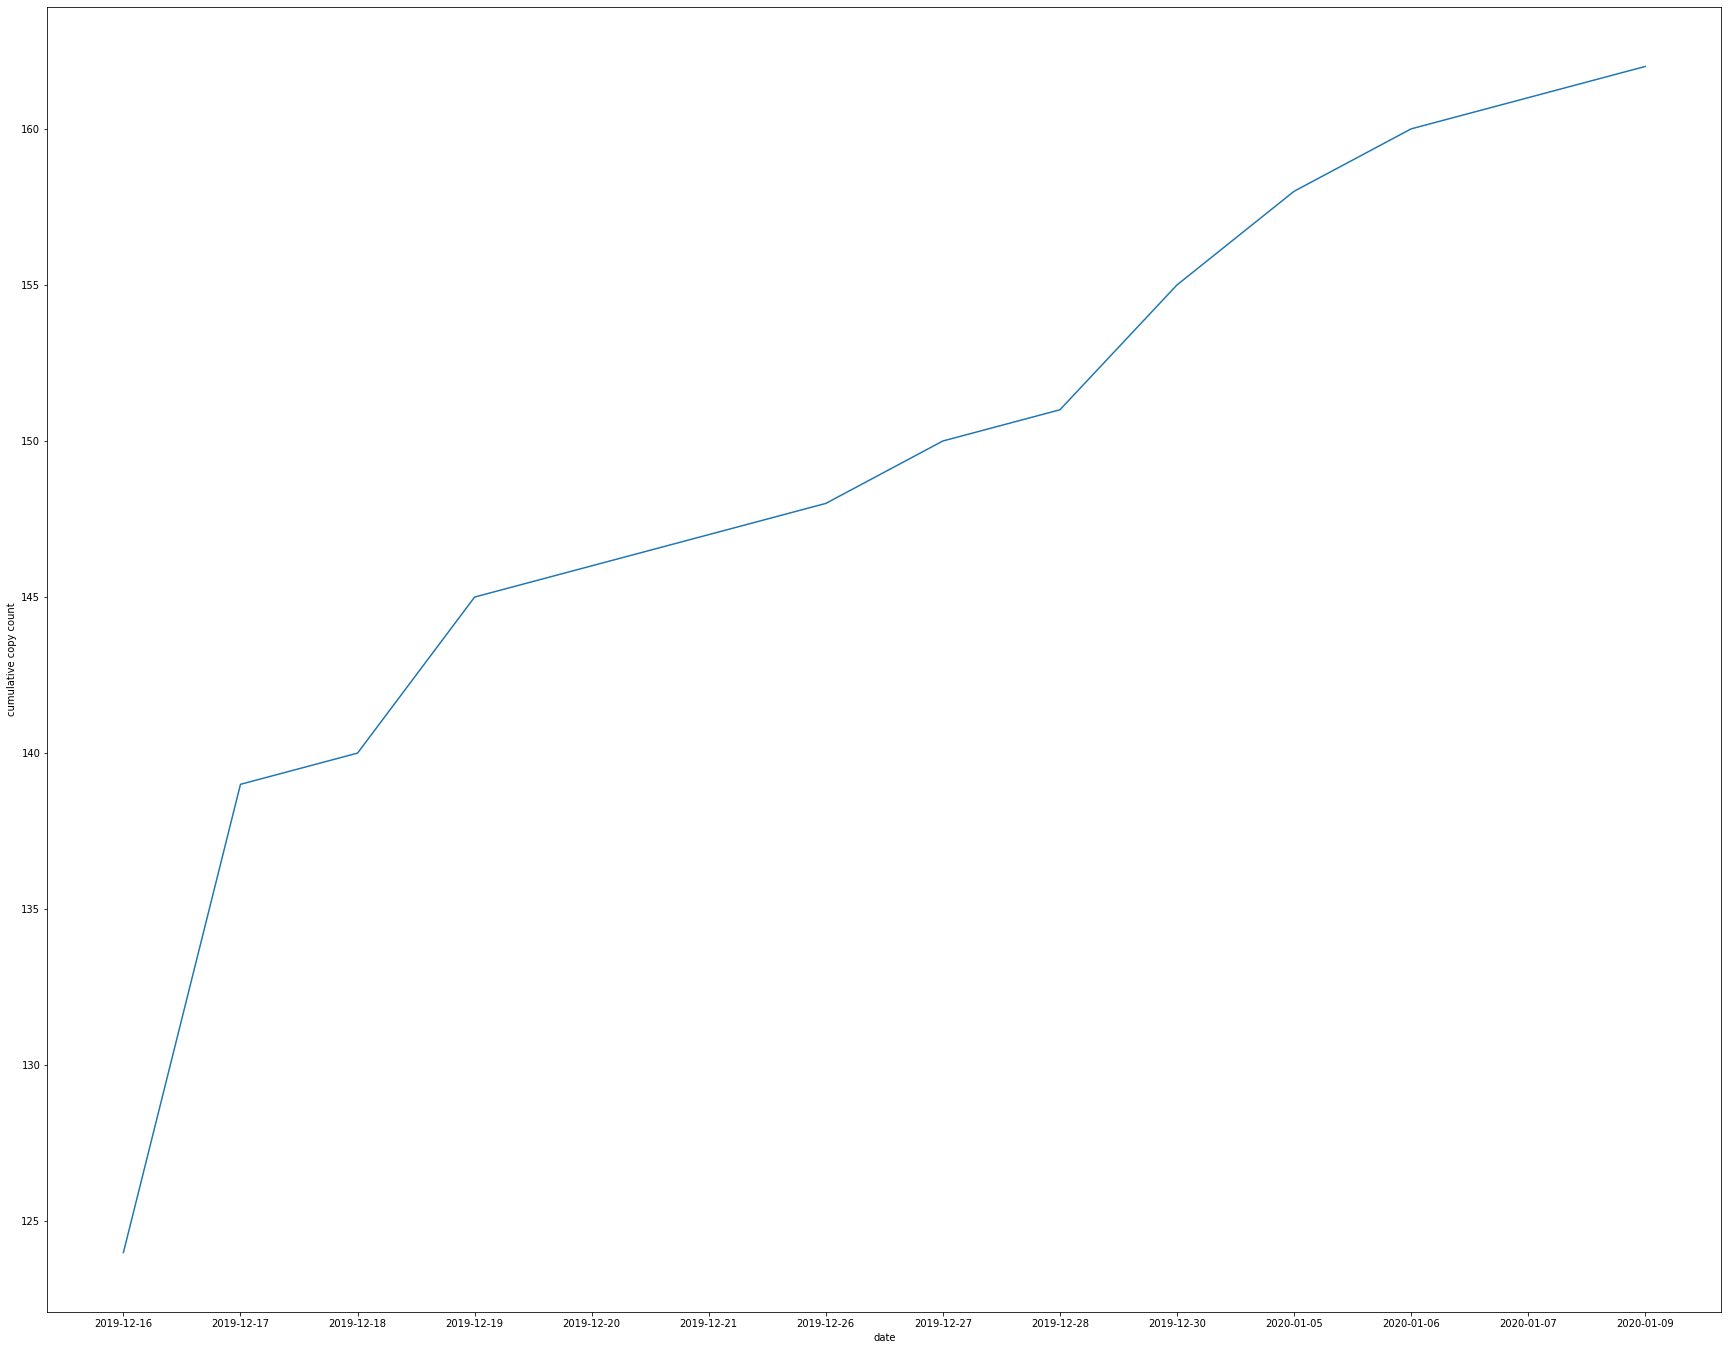

In [544]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(dates,cum_counts)
plt.xlabel('date')
plt.ylabel('cumulative copy count')
plt.show()

In [545]:
use1=df.loc[df['tweet_id'].isin(c_p_tweet)]
use2=pd.merge(use1,df_party_names,left_on='user_name',right_on='username')
use2.head()

,tweet_id,user_name,date,content,language,reply_count,retweet_count,like_count,hashtags,Unnamed: 0,...,location,id,url,public_metrics,protected,party,username,name,created_at,description
0,1206575016327827458,KunalChoudhary_,2019-12-16T14:01:15+00:00,Glimpses of the large number of people that ha...,en,2,28,110,['BJPBurningBharat'],374,...,"Bhopal, India",399437937,https://t.co/xJXXwBT8QU,"{'followers_count': 234670, 'following_count':...",False,Congress,KunalChoudhary_,Kunal Choudhary,2011-10-27T14:06:23.000Z,"MLA Kalapipal (M.P.) | Former President, Madhy..."
1,1206539448134987776,INCIndia,2019-12-16T11:39:55+00:00,Glimpses of the large number of people that ha...,en,163,1165,3877,['BJPBurningBharat'],359,...,"New Delhi, India",1153045459,https://t.co/51TS85KdYI,"{'followers_count': 8463703, 'following_count'...",False,Congress,INCIndia,Congress,2013-02-06T05:45:31.000Z,The Official Twitter Account of India's Most V...
2,1206502947271536640,INCIndia,2019-12-16T09:14:53+00:00,Watch: Images from across the country of stude...,en,181,845,2256,['BJPBurningBharat'],359,...,"New Delhi, India",1153045459,https://t.co/51TS85KdYI,"{'followers_count': 8463703, 'following_count'...",False,Congress,INCIndia,Congress,2013-02-06T05:45:31.000Z,The Official Twitter Account of India's Most V...
3,1206479321591930880,INCIndia,2019-12-16T07:41:00+00:00,The aftermath of BJP's unconstitutional Citize...,en,78,373,832,['BJPBurningBharat'],359,...,"New Delhi, India",1153045459,https://t.co/51TS85KdYI,"{'followers_count': 8463703, 'following_count'...",False,Congress,INCIndia,Congress,2013-02-06T05:45:31.000Z,The Official Twitter Account of India's Most V...
4,1206538323180707840,nsui,2019-12-16T11:35:27+00:00,Statement by Congress President Smt. Sonia Gan...,en,1,37,91,"['BJPBurningBharat', 'JamiaProtest']",362,...,"5 A, Raisina Road, New Delhi",16323656,https://t.co/otozWNPLdO,"{'followers_count': 473719, 'following_count':...",False,Congress,nsui,NSUI,2008-09-17T04:19:44.000Z,Official handle of National Students' Union of...


In [546]:
print(dates)

['2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21', '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-30', '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-09']
